In [1]:
!git clone -b main https://github.com/nguyenrtm/DDI-KT-2024.git
!pip install xmltodict
!python -m spacy download en_core_web_lg

Cloning into 'DDI-KT-2024'...
remote: Enumerating objects: 1778, done.
remote: Counting objects: 100% (741/741), done.
remote: Compressing objects: 100% (464/464), done.
remote: Total 1778 (delta 270), reused 733 (delta 262), pack-reused 1037
Receiving objects: 100% (1778/1778), 71.80 MiB | 15.60 MiB/s, done.
Resolving deltas: 100% (913/913), done.
Updating files: 100% (1536/1536), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
import sys
sys.path.append('./DDI-KT-2024')
sys.path.append('./DDI-KT-2024/src')

In [3]:
from tqdm import tqdm
from pprint import pprint

from utils import *
from reader.ddi_reader import *
from preprocess.spacy_nlp import *
from preprocess.clean import *
from dependency_parsing.dependency_parser import *
from dependency_parsing.path_processer import *
from model.custom_dataset import *
from model.word_embedding import *
from model.trainer import *
from model.model import *

In [20]:
lookup_word = get_lookup('./DDI-KT-2024/cache/fasttext/nguyennb/all_words.txt')
lookup_tag = get_lookup('./DDI-KT-2024/cache/fasttext/nguyennb/all_pos.txt')
lookup_dep = get_lookup('./DDI-KT-2024/cache/fasttext/nguyennb/all_dep.txt')
lookup_direction = get_lookup('./DDI-KT-2024/cache/fasttext/nguyennb/all_direction.txt')

In [5]:
reader = DDICorpusXMLReader('/kaggle/working/DDI-KT-2024/data/DDICorpus')
db_train, ml_train = reader.read_folder('train')
db_train = convert_all_list(db_train)
ml_train = convert_all_list(ml_train)
db_train = get_candidates(db_train)
ml_train = get_candidates(ml_train)

In [6]:
db_test, ml_test = reader.read_folder('ddiextraction_test')
db_test = convert_all_list(db_test)
ml_test = convert_all_list(ml_test)
db_test = get_candidates(db_test)
ml_test = get_candidates(ml_test)

In [7]:
all_candidates_train = db_train + ml_train
all_candidates_test = db_test + ml_test

In [14]:
all_candidates_train[0]

{'label': 'false',
 'id': 'DDI-DrugBank.d519.s3.p0',
 'text': 'Laboratory Tests Response to Plenaxis should be monitored by measuring serum total testosterone concentrations just prior to administration on Day 29 and every 8 weeks thereafter.',
 'e1': {'@id': 'DDI-DrugBank.d519.s3.e0',
  '@charOffset': '29-36',
  '@type': 'brand',
  '@text': 'Plenaxis'},
 'e2': {'@id': 'DDI-DrugBank.d519.s3.e1',
  '@charOffset': '83-94',
  '@type': 'drug',
  '@text': 'testosterone'}}

In [11]:
dp = DependencyParser(SpacyNLP().nlp)

In [27]:
all_candidates_train[3000]

{'label': 'false',
 'id': 'DDI-DrugBank.d64.s87.p998',
 'text': 'Drugs that reportedly may increase oral anticoagulant response, ie, increased prothrombin response, in man include:alcohol*;allopurinol;aminosalicylic acid;amiodarone;anabolic steroids;antibiotics;bromelains;chloral hydrate*;chlorpropamide;chymotrypsin;cimetidine;cinchophen;clofibrate;dextran;dextrothyroxine;diazoxide;dietary deficiencies;diflunisal;disulfiram;drugs affecting blood elements;ethacrynic acid;fenoprofen;glucagon;hepatotoxic drugs;ibuprofen;indomethacin;influenza virus vaccine;inhalation anesthetics;mefenamic acid;methyldopa;methylphenidate;metronidazole;miconazole;monoamine oxidase inhibitors;nalidixic acid;naproxen;oxolinic acid;oxyphenbutazone;pentoxifylline;phenylbutazone;phenyramidol;phenytoin;prolonged hot weather;prolonged narcotics;pyrazolones;quinidine;quinine;ranitidine*;salicylates;sulfinpyrazone;sulfonamides, long acting;sulindac;thyroid drugs;tolbutamide;triclofos sodium;trimethoprim/sulfamethoxa

In [10]:
dp.render("Laboratory Tests Response to Plenaxis should be monitored by measuring serum total testosterone concentrations just prior to administration on Day 29 and every 8 weeks thereafter.")

In [15]:
path = dp.get_sdp_one(all_candidates_train[0])

In [82]:
dp = DependencyParser(SpacyNLP().nlp)
sdp_train = dp.get_sdp_all(all_candidates_train)
sdp_test = dp.get_sdp_all(all_candidates_test)

100%|██████████| 5716/5716 [14:02<00:00,  6.78it/s]


In [21]:
pp = PathProcesser(SpacyNLP(), lookup_word, lookup_dep, lookup_tag, lookup_direction)

In [23]:
path

[(4, ('reverse', 'pobj'), 3),
 (3, ('reverse', 'prep'), 2),
 (2, ('reverse', 'nsubjpass'), 7),
 (7, ('forward', 'prep'), 8),
 (8, ('forward', 'pcomp'), 9),
 (9, ('forward', 'dobj'), 13),
 (13, ('forward', 'compound'), 12)]

In [22]:
pp.create_mapping(all_candidates_train[0], path)

tensor([[ 3375,    24,     0,    -8,     1,     0,     2,    36, 11747,    16,
            -1,    -9,     0,     0],
        [11747,    16,    -1,    -9,     0,     0,     2,    40,  3599,    24,
            -2,   -10,     0,     0],
        [ 3599,    24,    -2,   -10,     0,     0,     2,    31,  9047,    41,
             3,    -5,     0,     0],
        [ 9047,    41,     3,    -5,     0,     0,     1,    40,  5338,    16,
             4,    -4,     0,     0],
        [ 5338,    16,     4,    -4,     0,     0,     1,    35,  8772,    40,
             5,    -3,     0,     0],
        [ 8772,    40,     5,    -3,     0,     0,     1,    22,  5848,    26,
             9,     1,     0,     0],
        [ 5848,    26,     9,     1,     0,     0,     1,    15, 11614,    23,
             8,     0,     0,     1]])

In [8]:
sdp_train_mapped = pp.create_mapping_all(all_candidates_train, sdp_train)
sdp_test_mapped = pp.create_mapping_all(all_candidates_test, sdp_test)

In [18]:
all_candidates_train = load_pkl('./DDI-KT-2024/cache/pkl/v2/notprocessed.candidates.train.pkl')
all_candidates_test = load_pkl('./DDI-KT-2024/cache/pkl/v2/notprocessed.candidates.test.pkl')
sdp_train = load_pkl('./DDI-KT-2024/cache/pkl/v2/notprocessed.sdp.train.pkl')
sdp_test = load_pkl('./DDI-KT-2024/cache/pkl/v2/notprocessed.sdp.test.pkl')
sdp_train_mapped = load_pkl('./DDI-KT-2024/cache/pkl/v2/notprocessed.mapped.sdp.train.pkl')
sdp_test_mapped = load_pkl('./DDI-KT-2024/cache/pkl/v2/notprocessed.mapped.sdp.test.pkl')
we = WordEmbedding(fasttext_path='./DDI-KT-2024/cache/fasttext/nguyennb/fastText_ddi.npz',
                   vocab_path='./DDI-KT-2024/cache/fasttext/nguyennb/all_words.txt')

In [10]:
y_train = get_labels(all_candidates_train)
y_test = get_labels(all_candidates_test)

In [11]:
data_train = CustomDataset(sdp_train_mapped, y_train)
data_train.fix_exception()
data_train.batch_padding(batch_size=128, min_batch_size=3)
data_train.squeeze()
data_test = CustomDataset(sdp_test_mapped, y_test)
data_test.fix_exception()
data_test.batch_padding(batch_size=128, min_batch_size=3)
data_test.squeeze()

In [12]:
from torch.utils.data import DataLoader

dataloader_train = DataLoader(data_train, batch_size=128)
dataloader_test = DataLoader(data_test, batch_size=128)

In [13]:
import wandb

wandb.login()
wandb.init(
    # Set the project where this run will be logged
    project="DDI-KT-2024",
    # Track hyperparameters and run metadata
    config={
        "representation": "SDP",
        "preprocess": "None",
        "features": "fasttext, tag, position",
        "weight_decay": 1e-3,
        "lr": 0.0001,
        "batch_size": 128,
        "epochs": 300,
        "dropout_rate": 0,
        "word_embedding_size": 200,
        "tag_number": 51,
        "tag_embedding_size": 50,
        "position_number": 4,
        "position_embedding_size": 50,
        "direction_number": 3,
        "direction_embedding_size": 50,
        "edge_number": 46,
        "edge_embedding_size": 200,
        "token_embedding_size": 500,
        "dep_embedding_size": 500,
        "conv1_out_channels": 256,
        "conv2_out_channels": 256,
        "conv3_out_channels": 256,
        "conv1_length": 1,
        "conv2_length": 2,
        "conv3_length": 3,
        "w_false": 27792 / 23771,
        "w_advice": 27792 / 826,
        "w_effect": 27792 / 1687,
        "w_mechanism": 27792 / 1319,
        "w_int": 27792 / 189,
        "device": "cuda"
    }
)
config = wandb.config

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nguyenrtm (re-2023). Use `wandb login --relogin` to force relogin


In [14]:
model = Trainer(we,
                dropout_rate=config.dropout_rate,
                word_embedding_size=config.word_embedding_size,
                tag_number=config.tag_number,
                tag_embedding_size=config.tag_embedding_size,
                position_number=config.position_number,
                position_embedding_size=config.position_embedding_size,
                direction_number=config.direction_number,
                direction_embedding_size=config.direction_embedding_size,
                edge_number=config.edge_number,
                edge_embedding_size=config.edge_embedding_size,
                token_embedding_size=config.token_embedding_size,
                dep_embedding_size=config.dep_embedding_size,
                conv1_out_channels=config.conv1_out_channels,
                conv2_out_channels=config.conv2_out_channels,
                conv3_out_channels=config.conv3_out_channels,
                conv1_length=config.conv1_length,
                conv2_length=config.conv2_length,
                conv3_length=config.conv3_length,
                w_false=config.w_false,
                w_advice=config.w_advice,
                w_effect=config.w_effect,
                w_mechanism=config.w_mechanism,
                w_int=config.w_int,
                target_class=5,
                lr=config.lr,
                weight_decay=config.weight_decay,
                device='cuda')

In [15]:
model.train(dataloader_train, dataloader_test, num_epochs=config.epochs)

100%|██████████| 300/300 [37:01<00:00,  7.41s/it]


train_loss,█▆▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_f_advise,▁▃▄▄▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇█▇████▅██▇▇█▃█▇█▇▇▇██
val_f_effect,▁▂▂▃▄▇▇▇▅▇█▇▇█████▇▇███▇▇▇▇█▇▇▆▅█▇▇▆▇▇▇▇
val_f_false,▂▁▁▃▅▆▆▇▆▇▇▇▇▇▇▇████▇██████████▇█▇█▇█▇██
val_f_int,▅▁▂▂▄▅▅▅▆▆▆▆▅▇▆▇▆▇▆▇▇▇█▇██▇▇█▇█▇▇▇▇█▇▇▇▇
val_f_mechanism,▁▁▂▅▅▄▄▄▅▅▇▇██▇▇▇▇▆▇▆▇▆▇▆▆█▆▅▇▅▇▇▇▆▆▆▆▇▇
val_loss,█▅▂▄▂▂▁▄▃▂▆▄▃▃▄▃▅▄▆▆▄▅▄▆▆▅▆▇▆█▇▇▇▄▆▅▇▅█▆
val_micro_f1,▁▂▂▃▅▆▆▇▆▇██▇█████▇██████▇██▇█▇▆███▇▇▇██
train_loss,1032.91719
val_f_advise,0.44
val_f_effect,0.5372


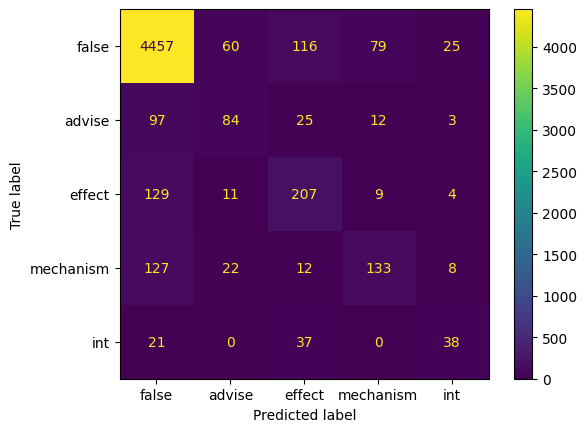

In [37]:
import sklearn
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=model.plot_confusion_matrix(dataloader_test),
                              display_labels=['false', 'advise', 'effect', 'mechanism', 'int'])
disp.plot()